Iniciaremos descargando la paqueteria de yfinance para ver los datos de yahoo finanzas

In [62]:
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


usaremos la siguiente formula iterativa para el movimiento browniano 

$$S(t_{i+1})=S(t_i)exp(\mu - \frac{1}{2}\sigma^2)(t_{i+1}- t_i) + \sigma \sqrt{t_{i+1}-t_i} Z_{i+1}$$

In [63]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [65]:
import numpy as np
import pandas as pd
import yfinance as yf

Se descargaran los datos del índice Standard & Poor's 500, que es uno de los indices mas famosos 

In [66]:
RISKY_ASSET = '^GSPC'
START_DATE = '2021-01-01'
END_DATE = '2022-06-01'

berificamos que si se bajaran los datos necesarios 

In [174]:
df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

[*********************100%***********************]  1 of 1 completed
Descargados 355 renglones de datos.


In [173]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5080870000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4764180000
...,...,...,...,...,...,...
2022-05-24,3942.939941,3955.679932,3875.129883,3941.479980,3941.479980,3901640000
2022-05-25,3929.590088,3999.330078,3925.030029,3978.729980,3978.729980,4322190000
2022-05-26,3984.600098,4075.139893,3984.600098,4057.840088,4057.840088,3961940000


procedemos a calcular los rendimientos de la columna Adj Close y observamos la grafica

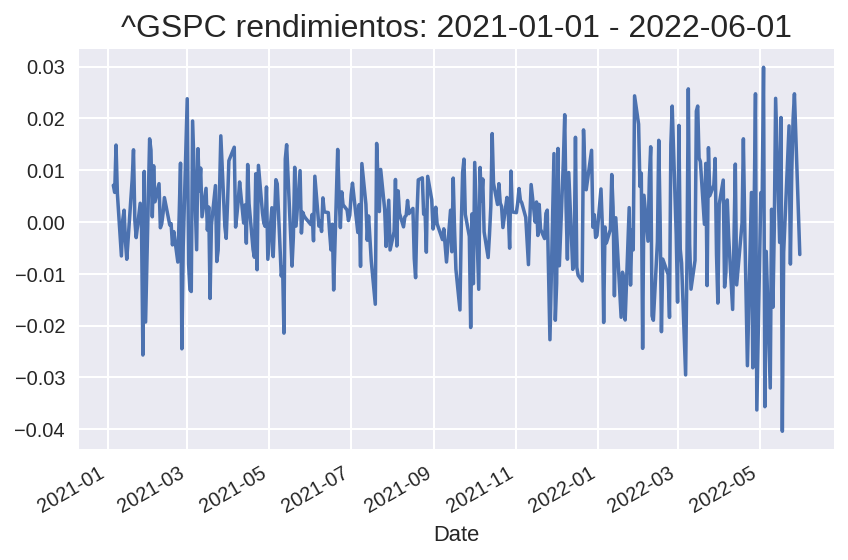

Rendimiento promedio: 0.04%


In [175]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

graficamos el histograma 

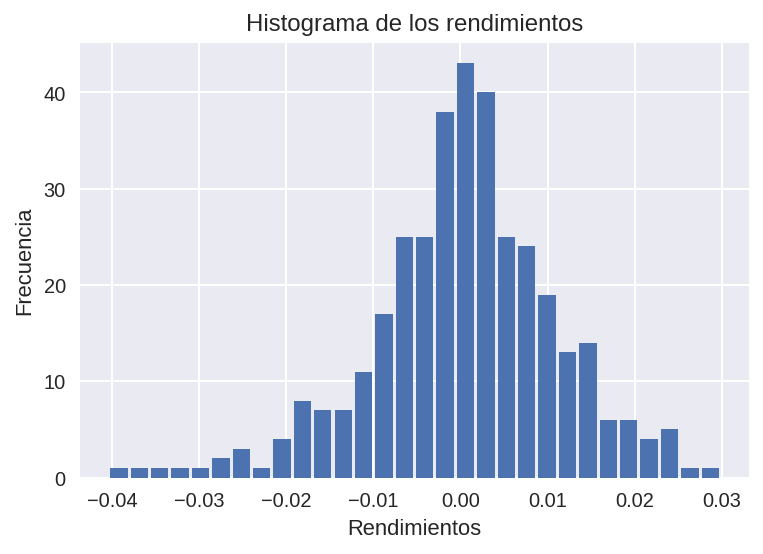

In [70]:
plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

claramente sigue una distribucion normal. Dividimos los datos observamos los 3 conjuntos de entrenamiento y prueba 

In [187]:
train0 = returns['2021-01-01':'2022-04-30']
test0 = returns['2022-05-01':'2022-06-01']

In [188]:
print(len(train0),len(test0))

333 21


In [189]:
train1 = returns['2021-01-01':'2022-03-31']
test1 = returns['2022-04-01':'2022-06-01']

In [190]:
print(len(train1),len(test1))

313 41


In [255]:
train2 = returns['2021-01-01':'2022-01-31']
test2 = returns['2022-02-01':'2022-06-01']

In [256]:
print(len(train2),len(test2))

271 83


In [224]:
T = len(test0)   # longitud del periodo de predicción
N = len(test0)   # número de incrementos unitarios en el periodo de predicción
S_00 = adj_close[train0.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu0 = train0.mean()    
sigma0 = train0.std()

In [225]:
T1 = len(test1)   # longitud del periodo de predicción
N1 = len(test1)   # número de incrementos unitarios en el periodo de predicción
S_01 = adj_close[train1.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu1 = train1.mean()    
sigma1 = train1.std()

In [257]:
T2 = len(test2)   # longitud del periodo de predicción
N2 = len(test2)   # número de incrementos unitarios en el periodo de predicción
S_02 = adj_close[train2.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu2 = train2.mean()    
sigma2 = train2.std()

In [258]:
print(N2)

83


In [227]:
mu0, sigma0

(0.0003810564021969053, 0.00999978993143381)

In [228]:
mu1, sigma1

(0.0006915906401694481, 0.009502144287213882)

In [229]:
mu2, sigma2

(0.00038845556839968854, 0.01078118536069023)

In [230]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t

In [248]:
gbm_simulations = simulate_gbm(S_00, mu0, sigma0, N_SIM, T, N)

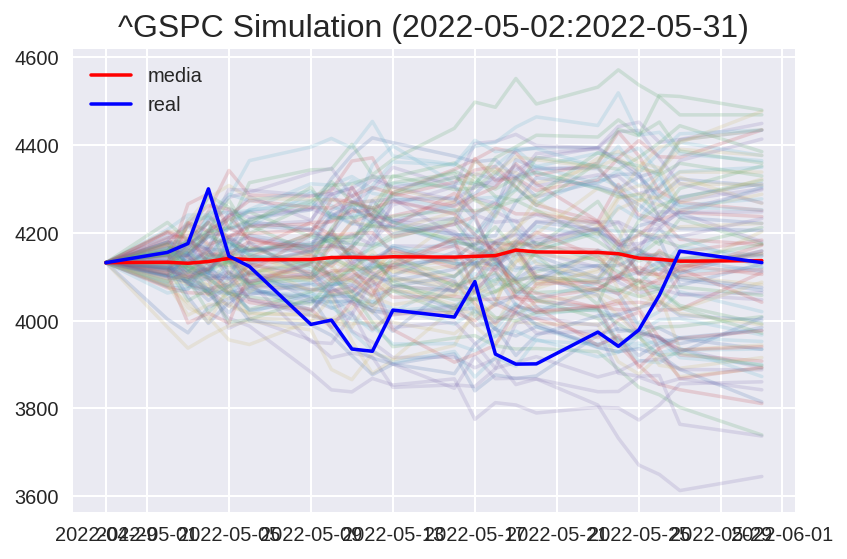

In [250]:
last_train_date = train0.index[-1].date()
first_test_date = test0.index[0].date()
last_test_date = test0.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

In [243]:
gbm_simulations = simulate_gbm(S_01, mu1, sigma1, N_SIM, T1, N1)

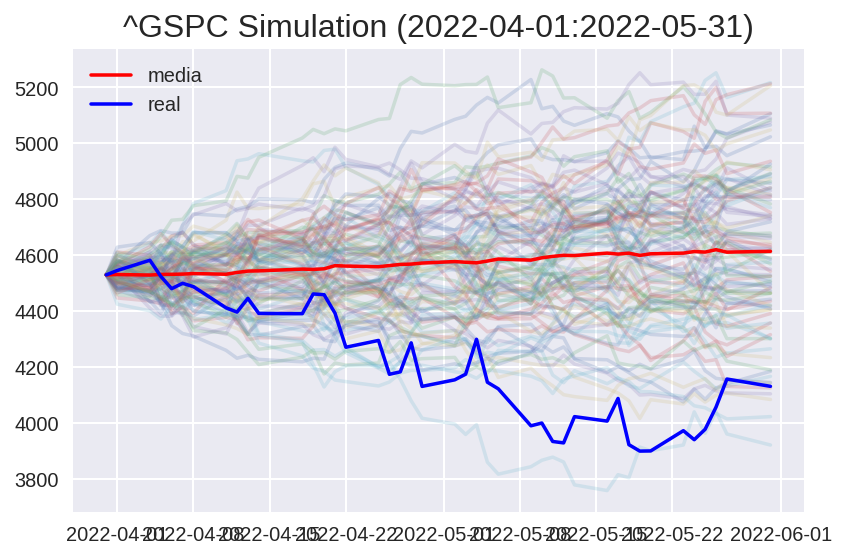

In [244]:
last_train_date = train1.index[-1].date()
first_test_date = test1.index[0].date()
last_test_date = test1.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

In [259]:
gbm_simulations = simulate_gbm(S_02, mu2, sigma2, N_SIM, T2, N2)

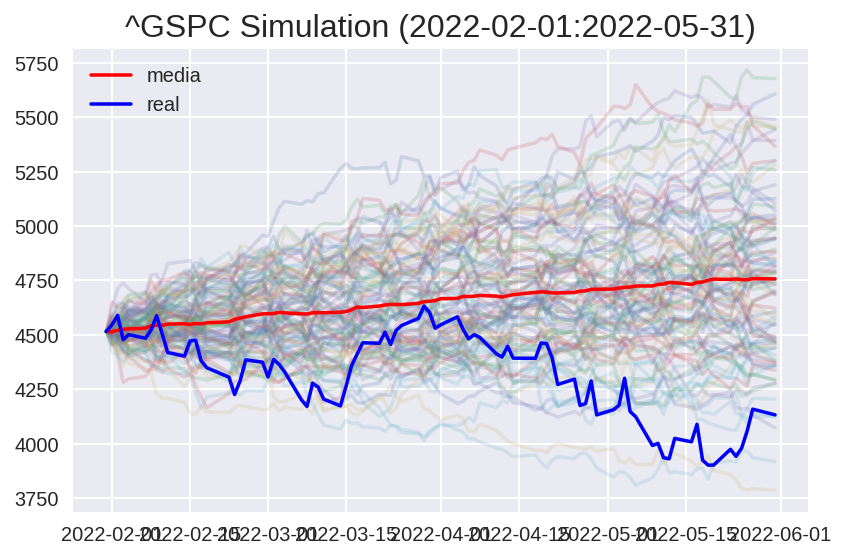

In [260]:
last_train_date = train2.index[-1].date()
first_test_date = test2.index[0].date()
last_test_date = test1.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)

# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()

Las 3 graficas claramente nos dicen que el indice va a la baja y entrando a Yahoo Finanzas podemos ver que claramente el precio a venido a la baja el ultimo año:

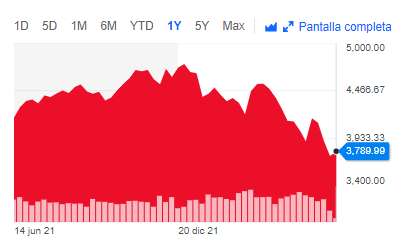